# Practical 4: Distance calculations

In the last practical we took some time diving into coordinate reference systems and transforming latitude and longitude coordinates into projected spatial reference systems. We also saw how the choice of CRS matters for the appearance of the map and possible size and shape distortions that are introduced.

In this practical, we will return to projected coordinate systems again, but this time we will be exploring distance measurements. Along the way, we'll also see a few more tricks for accessing geometry coordinates, iterating over rows, and a few more projections

Objectives:
* understand the difference between great-circle, geodesic, and Euclidean distance measurements
* implement a point-to-point distance calculation
* identify nearest neighbours in spatial datasets


## Distance calculations in GeoPandas

As with many other things geometry-related, GeoPandas uses `shapely` to manage most distance calculations. One consequence of this is that `shapely` geometries assume a cartesian coordinate system, so we need to (again) be careful when we're working with a geographic coordinate system (i.e. latitude and longitude). We'll see how distance calculations work first with just simple geometries and then we'll return to GeoDataFrames and consider some options for measuring distances on the earth. 

In [1]:
# load packages
import math
from shapely.geometry import Point, Polygon

In [2]:
# create some geometries
pt1 = Point(1,1)
pt2 = Point(6,3)

In [3]:
# calculate the distance between the points
pt1.distance(pt2)

5.385164807134504

In [4]:
# which is what we expect...
# notice how we can get the coordinates with `.x` and `.y`
math.sqrt((pt2.y - pt1.y)**2 + (pt2.x - pt1.x)**2)

5.385164807134504

In [5]:
# distance also works with other geometries
# remember how we created a shape with a list of vertices
poly1 = Polygon([(3, 0), (5, 1), (5, 4), (3.5, 4)])

In [6]:
# distance calculation (point to polygon)
pt1.distance(poly1)

2.1085904880165436

The distance calculation finds the minimum separating distance between the geometries, but where (on the polygon) is that closest point? It's not necessarily at a vertex. `shapely` can also find that location for us.

In [7]:
from shapely.ops import nearest_points

In [8]:
# find the nearest point. Not necessarily a vertex
near_p = nearest_points(pt1, poly1)

# we get a pair of points back (on the first and the second geometry)
# notice how `.wkt` will print out the coordinates
[o.wkt for o in near_p]

['POINT (1 1)', 'POINT (3.092307692307692 0.7384615384615385)']

In [9]:
# confirm what we know about the distances
# instead of measuring point to polygon, we measure point to near-point
pt1.distance(near_p[1])

# this should be the same answer we got above with `.distance`

2.1085904880165436

In the example above, we're measure from a point to a polygon. This works between two polygons, lines, and any combination. Notice that the second point (the near point on the square) is not a vertex.

There are many useful geometry methods built into `shapely`. This includes spatial relationships, calculating things like Voronois, and other features. Check the documentation here: [https://shapely.readthedocs.io/en/latest/manual.html](https://shapely.readthedocs.io/en/latest/manual.html)

### Returning now to GeoPandas

In [10]:
# load packages
import geopandas as gpd

#### Global cities

For this practical we'll now start working with some point locations of global cities. The long distances will help to show the potential scale of distortion between different distance measurements. Load the data from within GeoPandas and have a look at it.

In [11]:
# load the data
cities = gpd.read_file(gpd.datasets.get_path('naturalearth_cities'))

cities.crs # note the projection

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [12]:
cities.head()

,name,geometry
0,Vatican City,POINT (12.45339 41.90328)
1,San Marino,POINT (12.44177 43.93610)
2,Vaduz,POINT (9.51667 47.13372)
3,Luxembourg,POINT (6.13000 49.61166)
4,Palikir,POINT (158.14997 6.91664)


<AxesSubplot:>

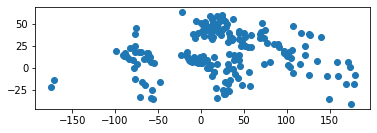

In [13]:
cities.plot()

## Implementing distance measures on the earth

Let's jump in to see how some different approach work.

In [14]:
# first extract two cities that we'll use for the calculations
# I'm choosing two fairly distance cities to exaggerate the differences
# note adding `.reset_index` to avoid issue later when working with the Series
london = cities.loc[cities['name'] == 'London'].reset_index()
singapore = cities.loc[cities['name'] == 'Singapore'].reset_index()

In [15]:
london

,index,name,geometry
0,187,London,POINT (-0.11867 51.50194)


In [16]:
singapore

,index,name,geometry
0,201,Singapore,POINT (103.85387 1.29498)


### Euclidean distance

The simplest formula for straight-line distance calculations in two dimension is with Euclidean distance: $d(p,q) = \sqrt{(q_{1} - p_{1})^2 + (q_{2} - p_{2})^2}$. 

That's what we used before, and that's what `shapely` assumes, but we know this approach violates our assumptions of an ellipsoidal earth. Our best best is to find an appropriate projection for our area of interest, reproject our data, and then measure the distances.

However, if we want to measure distances on a globe, we're better off using a geodesic or great-circle measurement.

In [17]:
# not the correct way to measure an accurate distance
# we're still using a geographic coordinate system (WGS84)
london.distance(singapore)

<ipython-input-17-652651b09556>:3: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  london.distance(singapore)


0    115.460073
dtype: float64

### Great-circle distance

The great-circle distance is between two points as measured along a spherical surface. These curved lines connecting to points are referred to as *geodesics* and are part of a circle, or *great-circle* on the sphere.

If we were to use Euclidean distance on a sphere we wouldn't travel over the surface, but cut right through. In reality, when measuring short distances, violating that assumption won't introduce huge errors. There are other sources of error, too, like differences in elevation. If we were surveyors trying to plan a bridge, we would really want to be careful about these things.

But all great-circle distances require an assumption of a spherical earth. That's a simplification, and we'll use a constant value for the radius of that earth sphere (another simplifying assumption).

#### Haversine Formula

One of the most common ways to implement a great-circle distance calculation is using the **haversine** formula. Given two point locations in latitude ($\phi$) and longitude ($\lambda$) expressed in radians, the difference can be expressed as the central angle between the two ($\Delta\sigma$).

From there, the distance, $d$, of an arc along a sphere with radius $R$, becomes $d = R\Delta\sigma$. Calculating the central angle has typically used a haversine function ($hav(\theta) = \sin^2(\frac{\theta}{2})$), which is where the name for this approach comes from.

You can read more about the maths here: [https://en.wikipedia.org/wiki/Haversine_formula](https://en.wikipedia.org/wiki/Haversine_formula)

Simplified, we will work with: 

$a = hav(\Delta\phi) + \cos(\phi_1) * \cos(\phi_2) * hav(\Delta\lambda)$

and

$d = 2 * R * \arctan({\sqrt{a}, \sqrt{1-a}})$


In [18]:
# implement a haversine function
# use tuples of point coordinates in lon, lat
def d_haversine(p1, p2):
    # define a constant for the earth's radius
    R = 6371  # kilometers, approximately
    
    lon1, lat1 = p1
    lon2, lat2 = p2
    
    # note: convert to radians
    phi1, phi2 = math.radians(lat1), math.radians(lat2)
    delta_phi = math.radians(lat2 - lat1)
    delta_lam = math.radians(lon2 - lon1)
    
    a = math.sin(delta_phi / 2)**2 + \
    math.cos(phi1) * math.cos(phi2) * \
    math.sin(delta_lam/2)**2
    
    # distance in km (because of R)
    d = 2 * R * math.atan2(math.sqrt(a), math.sqrt(1-a))
    
    return d

In [19]:
# use the haversine distance function

# create two pairs of coordinates
# notice how we can access the geometry coordinates directly
# we use `.values` to convert from pd.Series to an array of values

pt1 = (london.geometry.x.values, london.geometry.y.values)
pt2 = (singapore.geometry.x.values, singapore.geometry.y.values)

# pass to the function
d_haversine(pt1, pt2)
# distance in kilometers

10854.694874084076

#### Using `geopy` for calcluations

There is another package within Python that can help us with these geodesic distance calculations: `geopy`. This package also implements a more sophisticated distance calculation that moves aways from the spherical assumption of the earth and allows for the "flattening".

The documentation is here: [https://geopy.readthedocs.io/en/latest/#module-geopy.distance](https://geopy.readthedocs.io/en/latest/#module-geopy.distance)

If you want to learn more about how to calculate a more accurate distance on the globe and not assume a sphere, Nathan Rooy has a nice example of Vincenty's formula here: [https://nathanrooy.github.io/posts/2016-12-18/vincenty-formula-with-python/](https://nathanrooy.github.io/posts/2016-12-18/vincenty-formula-with-python/).

We will now test `geopy`'s distance functions on our cities.

In [20]:
# import
import geopy.distance

In [21]:
# Great-circle distance
# points in lat, lon order
pt1 = (london.geometry.y.values, london.geometry.x.values)
pt2 = (singapore.geometry.y.values, singapore.geometry.x.values)

geopy.distance.great_circle(pt1, pt2)

Distance(10854.710207980463)

In [22]:
# Geodesic distance
geopy.distance.geodesic(pt1, pt2)

Distance(10859.201552808889)

## Using an Azimuthal projection

If we want to use a Euclidean distance formula, then our data need to be in planar coordinates, such as using a projected coordinate system (as we saw in the previous practical).

One family of projections that we didn't explore much are *azimuthal equidistant* projections. As the name implies, these projections provide accurate distance measurements, but they have a unique feature. They are centred on a specific point location. The distances from that central point are the most accurate. The user can "move" and redefine that point to any location by reprojecting the data thereby ensuring an accurate distance observation. Measuring between two, non-central locations, however, could still introduce some errors.

Azimuthal projections are particularly popular for data in polar regions.

### Example of an azimuthal projection

Based on: 

In order to project our data, we first have to write out a custom projection string. This is sometimes referred to as a `proj` string and it is a slightly different from from what we have used before.

This will define a custom version of a world azimuthal projection. The key input is the `lat_0` and `lon_0` parameters which specify the central location. We'll set these to be (approximately) London for this example.

In [23]:
# define the projection string
# notice that here we are using KM as units. We have that flexibility when we define a projection. 
# This could be m, too, if we wanted
azprj_txt = '+proj=aeqd \
             +lat_0=51.50194 \
             +lon_0=-0.11867 \
             +x_0=0 +y_0=0 \
             +ellps=WGS84 \
             +datum=WGS84 \
             +units=km \
             +no_defs'

<AxesSubplot:>

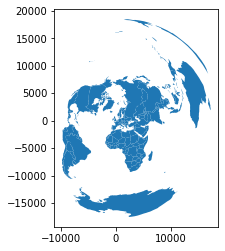

In [24]:
# to get a sense of this projection, let's use it on the countries outlines
countries = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

countries.to_crs(azprj_txt, inplace=True)  # notice we can do this change 'in place'

# visualise the results
countries.plot()

With this projection, the whole world is centred around London.

In [25]:
# let's now project our cities
lond_prj = london.to_crs(azprj_txt)
sing_prj = singapore.to_crs(azprj_txt)

In [26]:
# calculate the Euclidean distance
# default result is in KM because of our custom projection
lond_prj.distance(sing_prj)

0    10859.201553
dtype: float64

## Calculating multiple distances

So far we've looked at simple pairwise distances between two objects (usually points). It's often the case that we need to calculate multiple dsitances. For that we'll need to be able to be more efficient than writing out each pair. 

This task also gives us an opportunity to see how to efficiently iterate over observations in a GeoDataFrame. We will be using `apply` here, though another option that works with a GeoDataFrame is `iterrows`.

In [27]:
# define a helper function for distance
# `geopy.distance.distance defaults to a geodesic distance
def dist_pair(from_pt, to_pt):
    # create coordinate pair suitable for geopy
    from_pt = (from_pt.geometry.y, from_pt.geometry.x)
    
    d = geopy.distance.geodesic(from_pt, to_pt)
    
    return d

In [28]:
# `apply` the function to each row of the cities table
# remember that pt1 is a tuple of (lat, lon) for London created above
# store this distance in a new column
cities['lond_dist'] = cities.apply(dist_pair, to_pt=pt1, axis=1)

In [29]:
cities.head()

,name,geometry,lond_dist
0,Vatican City,POINT (12.45339 41.90328),1432.3155274896496 km
1,San Marino,POINT (12.44177 43.93610),1260.0876510215796 km
2,Vaduz,POINT (9.51667 47.13372),851.4100596291318 km
3,Luxembourg,POINT (6.13000 49.61166),489.98090878827503 km
4,Palikir,POINT (158.14997 6.91664),13207.74040521761 km


In [30]:
# sanity check... distance IS 0
cities.loc[cities['name']=='London']

,name,geometry,lond_dist
187,London,POINT (-0.11867 51.50194),0.0 km


**Note**: our "helper" function used methods from `geopy`. We could also write a helper function that implemented a Euclidean distance formula, used `shapely`'s `.distance`, or any of the other approaches we've looked at already.

## Nearest neighbour analysis

A related question to calculating multiple distances, is, "what is the next nearest city to each city?" In other words, find the nearest neighbour of a feature given a set of options. We saw how to do this between one point and one polygon earlier using `.nearest_points`. 

The trick to doing this, however, is that the set of points you want to compare against need to be combined into one geometry set. We need to create a `MultiPoint` geometry, and we can do that using `.geometry.unary_union`. 

This time we'll also use `iterrows` to see how that can be used.

In [31]:
# add a new column to the end
cities.insert(3, 'near_city', None)

cities.head()

,name,geometry,lond_dist,near_city
0,Vatican City,POINT (12.45339 41.90328),1432.3155274896496 km,None
1,San Marino,POINT (12.44177 43.93610),1260.0876510215796 km,None
2,Vaduz,POINT (9.51667 47.13372),851.4100596291318 km,None
3,Luxembourg,POINT (6.13000 49.61166),489.98090878827503 km,None
4,Palikir,POINT (158.14997 6.91664),13207.74040521761 km,None


In [32]:
# loop over cities GeoDataFrame by row
for index, row in cities.iterrows():
    # extract a city
    point = row.geometry
    
    # combine the remaining cities into one geometry
    # note `drop` to not consider the index (i.e. London is always closest to London)
    multipoint = cities.drop(index, axis=0).geometry.unary_union
    
    # check for nearest city
    index_geom, nearest_geom = nearest_points(point, multipoint)
    
    # get the record of closest point
    near_city = cities.loc[cities.geometry == nearest_geom]
    
    # update the name column with the returned values
    cities.loc[index, 'near_city'] = near_city['name'].values[0]

In [33]:
# see the modified GeoDataFrame
cities

,name,geometry,lond_dist,near_city
0,Vatican City,POINT (12.45339 41.90328),1432.3155274896496 km,Rome
1,San Marino,POINT (12.44177 43.93610),1260.0876510215796 km,Vatican City
2,Vaduz,POINT (9.51667 47.13372),851.4100596291318 km,Bern
3,Luxembourg,POINT (6.13000 49.61166),489.98090878827503 km,Brussels
4,Palikir,POINT (158.14997 6.91664),13207.74040521761 km,Majuro
...,...,...,...,...
197,Cairo,POINT (31.24802 30.05191),3513.2242348390846 km,Jerusalem
198,Tokyo,POINT (139.74946 35.68696),9584.855393206844 km,Seoul
199,Paris,POINT (2.33139 48.86864),341.1497487402804 km,Brussels
200,Santiago,POINT (-70.66899 -33.44807),11650.639325301892 km,Buenos Aires


In [34]:
# check the results for London
cities.loc[cities['name']=='London']

,name,geometry,lond_dist,near_city
187,London,POINT (-0.11867 51.50194),0.0 km,Paris


This practical has focused on distances that are straight lines or at least direct routes. That's one way to consider distance, but it's not the way. In geography we often use things like **network** distance, measured alone roads or other routes that take into consideration the turns. There's also more to understand to distance than just spacing. It's important to consider the **effort** to move in a certain path. This ideas leads to using types of "friction surface" or weighted distances that could consider the terrain (hilly, flat, swampy, etc.) or mode of transport (walking, bicycle, etc.).

It's also worth noting that there are other implemented distance metrics. We could be using tools from within `scipy.spatial.distance` to work with the point coordinates. That certainly can give us a few more options, but always remember the issues related to the coordiante reference system if you want to do that.

Finished!